# 评估AFNONet结合DDWP-DA论文的同化方法的预报技巧

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Depending on your combination of package versions, this can raise a lot of TF warnings... 
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import torch
import seaborn as sns
import pickle
import sys
sys.path.append('../')
from src.utils.score import *
from src.da_methods.spnekf import ENKF
from collections import OrderedDict

In [3]:
sns.set_style('darkgrid')
sns.set_context('notebook')

In [4]:
DATADIR = '../../data/test'

## 读取预测数据集

从.nc文件中读取数据，为后续预测技巧的验证提供基础数据支撑

In [5]:
# Load the validation subset of the data: 2017 and 2018
# 读取4个小时的数据对代码进行debug
z500_valid = load_test_data(f'{DATADIR}', 'z', years=slice('2018'))
valid = xr.merge([z500_valid])
valid

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 8760)
Coordinates:
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
    level    int32 ...
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * time     (time) datetime64[ns] 2018-01-01 ... 2018-12-31T23:00:00
Data variables:
    z        (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
Attributes:
    units:          m**2 s**-2
    long_name:      Geopotential
    standard_name:  geopotential

In [6]:
from pathlib import Path

with open(Path('../../data')/f'scaler.pkl', 'rb') as f:
    item = pickle.load(f)
    lon = item['lon']
    lat = item['lat']
    mean = item['mean']
    std = item['std']
    f.close()

mean, std

(54108.31062925485, 3352.3980519318557)

## 加载训练好的模型参数

In [7]:
from src.models.prednn_module import PredNNLitModule
module = PredNNLitModule.load_from_checkpoint('../../output/da4ddwp/6h/epoch_059-v1.ckpt')
afnonet = module.net

/home/wangwx/anaconda3/envs/ddwp/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:268: UserWarning: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.
  rank_zero_warn(
/home/wangwx/anaconda3/envs/ddwp/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:268: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(


## 构建预报结果

使用AFNONet做预测，将预测结果写入nc文件中

In [8]:
daw = 24

Z = valid['z'].values

obs = np.reshape(Z, [np.size(Z, 0), int(np.size(Z, 1)*np.size(Z, 2))])
obs = (obs-mean)/std

noise = 0.1

for k in range(0, np.size(obs,0)):
    obs[k,:] = obs[k,:] + np.random.normal(0, noise, np.size(obs, 1)) 

N = obs.shape[-1]

P = noise**2 * np.eye(N, N)

Q = 0.001 * np.eye(N, N) 

R = noise ** 2 

u_ensemble = np.zeros([N, 2*N])

obs = np.reshape(obs, [obs.shape[0], Z.shape[1], Z.shape[2]])

# obs = obs * std + mean

In [9]:
prediction_length = 41
prediction_type = 'iterative'
n_initial_conditions = 5
DECORRELATION_TIME = 3600
dt = 6

In [10]:
n_samples_per_year = len(valid['z'])//6
n_samples = n_samples_per_year - prediction_length
stop = n_samples
ics = np.arange(0, stop, DECORRELATION_TIME)
n_ics = len(ics)

valid_loss = []
acc = []
seq_pred = []
seq_real = []


In [11]:
def SPENKF(x, n, P ,Q, R, obs, model, u_ensemble, device):
   shape = x.shape
   obs=np.reshape(obs,[n,1]) 
   x=np.reshape(x.cpu().detach().numpy(),[n,1])
   # 对背景误差协方差进行SVD分解
   [U,S,V]=np.linalg.svd(P)
   D=np.zeros([n,n])
   np.fill_diagonal(D,S)
   # 求得扰动分量
   sqrtP=np.dot(np.dot(U,np.sqrt(D)),U)
   # 构造集合成员
   ens=np.zeros([n,2*n])
   # 前N个成员为加上扰动
   ens[:,0:n]=np.tile(x,(1,n)) + sqrtP
   # 后N个成员为减去扰动
   ens[:,n:]=np.tile(x,(1,n)) - sqrtP
   ## forecasting step,dummy model
   # 对集合进行预测
   for k in range(0, np.size(ens,1)):
      u =  model(torch.from_numpy(np.reshape(ens[:,k],[1, 1, 32, 64])).to(device, dtype=torch.float))
      u_ensemble[:,k]=np.reshape(u.cpu().detach().numpy(),(32*64,))

    ############################
   # 获得背景场的均值
   x_prior = np.reshape(np.mean(u_ensemble,1),[n,1])
   # print('shape pf x_prior',np.shape(x_prior))
   # print('shape pf obs',np.shape(obs))
   # 用于计算背景误差协方差
   cf_ens = ens - np.tile(x_prior,(1,2*n))
   # 背景误差协方差的计算，统计协方差矩阵，并添加模式误差项
   P_prior = np.dot(cf_ens,np.transpose(cf_ens))/(2*n - 1) + Q
   h_ens = ens
   # 计算观测误差
   y_prior=np.reshape(np.mean(h_ens,1),[n,1])
   ch_ens = h_ens - np.tile(y_prior,(1,2*n))
   # print('shape pf y_prior',np.shape(y_prior))
   # 观测误差协方差的构建
   P_y = np.dot(ch_ens, np.transpose(ch_ens))/(2*n-1) + R
   P_xy = np.dot(cf_ens, np.transpose(ch_ens)) /(2*n-1)
   # 计算增益矩阵
   K = np.dot(P_xy,np.linalg.inv(P_y))
   P = P_prior - np.dot(np.dot(K,P_y),np.transpose(K))
   x = x_prior + np.dot(K,(obs-y_prior))
   return torch.from_numpy(x.reshape(shape)).to(device, dtype=torch.float), P

In [34]:
def autoregressive_inference_with_enkf(ic, valid_data_full, obs_nc, P, Q, R, u_ensemble, model, dt, prediction_length):
    ic = int(ic)
    device = device = torch.cuda.current_device() if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    dt = dt
    daw_dt = daw // dt
    prediction_length = int(prediction_length)
    
    valid_loss = torch.zeros((prediction_length, 1)).to(device, dtype=torch.float)
    acc = torch.zeros((prediction_length, 1)).to(device, dtype=torch.float)
    seq_real = torch.zeros((prediction_length, 1, 32, 64)).to(device, dtype=torch.float)
    seq_pred = torch.zeros((prediction_length, 1, 32, 64)).to(device, dtype=torch.float)

    valid_data = valid_data_full['z'][ic:(ic+prediction_length*dt):dt].values #extract valid data from first year
    # standardize
    valid_data = (valid_data - mean)/std + np.random.normal(0, noise, np.size(valid_data[0])).reshape(valid_data[0].shape)
    valid_data = torch.as_tensor(valid_data).to(device, dtype=torch.float)

    with torch.no_grad():
        for i in range(valid_data.shape[0]):
            # 从ic开始
            if i==0: #start of sequence
                first = valid_data[0]
                future = valid_data[1]
                seq_real[0] = first[0] #extract history from 1st 
                seq_pred[0] = seq_real[0]
                # ic+dt的预测结果
                future_pred = model(torch.unsqueeze(torch.unsqueeze(first, dim=0), dim=0))
            else:
                # print(ic, i)
                # 存储下一时刻的真值
                if i < prediction_length-1:
                    future = valid_data[i+1]
                # 如果到了ic+3dt，那么准备做集合预报，并在第ic+4dt时刻做同化
                if (i+1) % daw_dt == 0:
                    future_pred, P = SPENKF(future_pred, N, P, Q, R, obs_nc[ic+(i+1)*dt], model, u_ensemble, device)
                else:
                    future_pred = model(future_pred) #autoregressive step
            
            if i < prediction_length-1: #not on the last step
                seq_pred[i+1] = future_pred
                seq_real[i+1] = future
                history_stack = seq_pred[i+1:i+2]

            future_pred = history_stack
            
            pred = torch.unsqueeze(seq_pred[i], 0)

        pred_nc = xr.DataArray(
            seq_pred[1:].cpu().detach().numpy() * std + mean,
            dims=['lead_time', 'time', 'lat', 'lon'],
            coords={
                'lead_time': np.arange(dt, prediction_length*dt, dt),
                'time': valid_data_full.time.values[ic:ic+1], 
                'lat': valid_data_full.lat.values, 
                'lon': valid_data_full.lon.values
            },
            name='z'
        )
            
    return pred_nc


In [35]:
fcs = []
rmse, acc = [], []
for i, ic in enumerate(ics):
    fcs.append(autoregressive_inference_with_enkf(ic, valid, obs, P, Q, R, u_ensemble, afnonet, dt, prediction_length))

In [36]:
fc_iter = xr.merge(fcs)
rmse = evaluate_iterative_forecast(fc_iter, valid, compute_weighted_rmse).compute()
acc = evaluate_iterative_forecast(fc_iter, valid, compute_weighted_acc).compute()

In [37]:
rmse.load()

<xarray.Dataset>
Dimensions:    (lead_time: 40)
Coordinates:
  * lead_time  (lead_time) int64 6 12 18 24 30 36 42 ... 210 216 222 228 234 240
    level      int32 500
Data variables:
    z          (lead_time) float64 246.0 251.9 292.9 385.0 ... 321.1 348.9 416.8

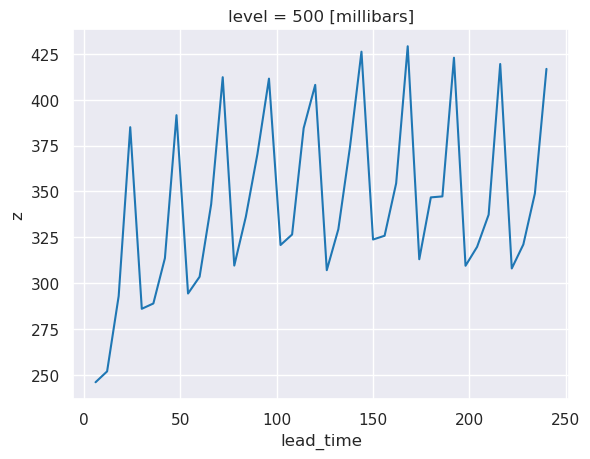

In [38]:
rmse.z.plot()



In [39]:
acc.load()

<xarray.Dataset>
Dimensions:    (lead_time: 40)
Coordinates:
  * lead_time  (lead_time) int64 6 12 18 24 30 36 42 ... 210 216 222 228 234 240
    level      int32 500
Data variables:
    z          (lead_time) float64 0.9733 0.9723 0.9629 ... 0.9633 0.956 0.9411

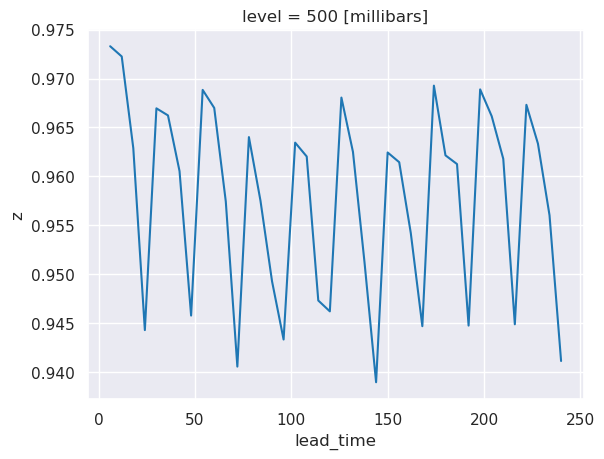

In [40]:
acc.z.plot()

/home/wangwx/anaconda3/envs/ddwp/lib/python3.8/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/wangwx/anaconda3/envs/ddwp/lib/python3.8/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/home/wangwx/anaconda3/envs/ddwp/lib/python3.8/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/home/wangwx/anac

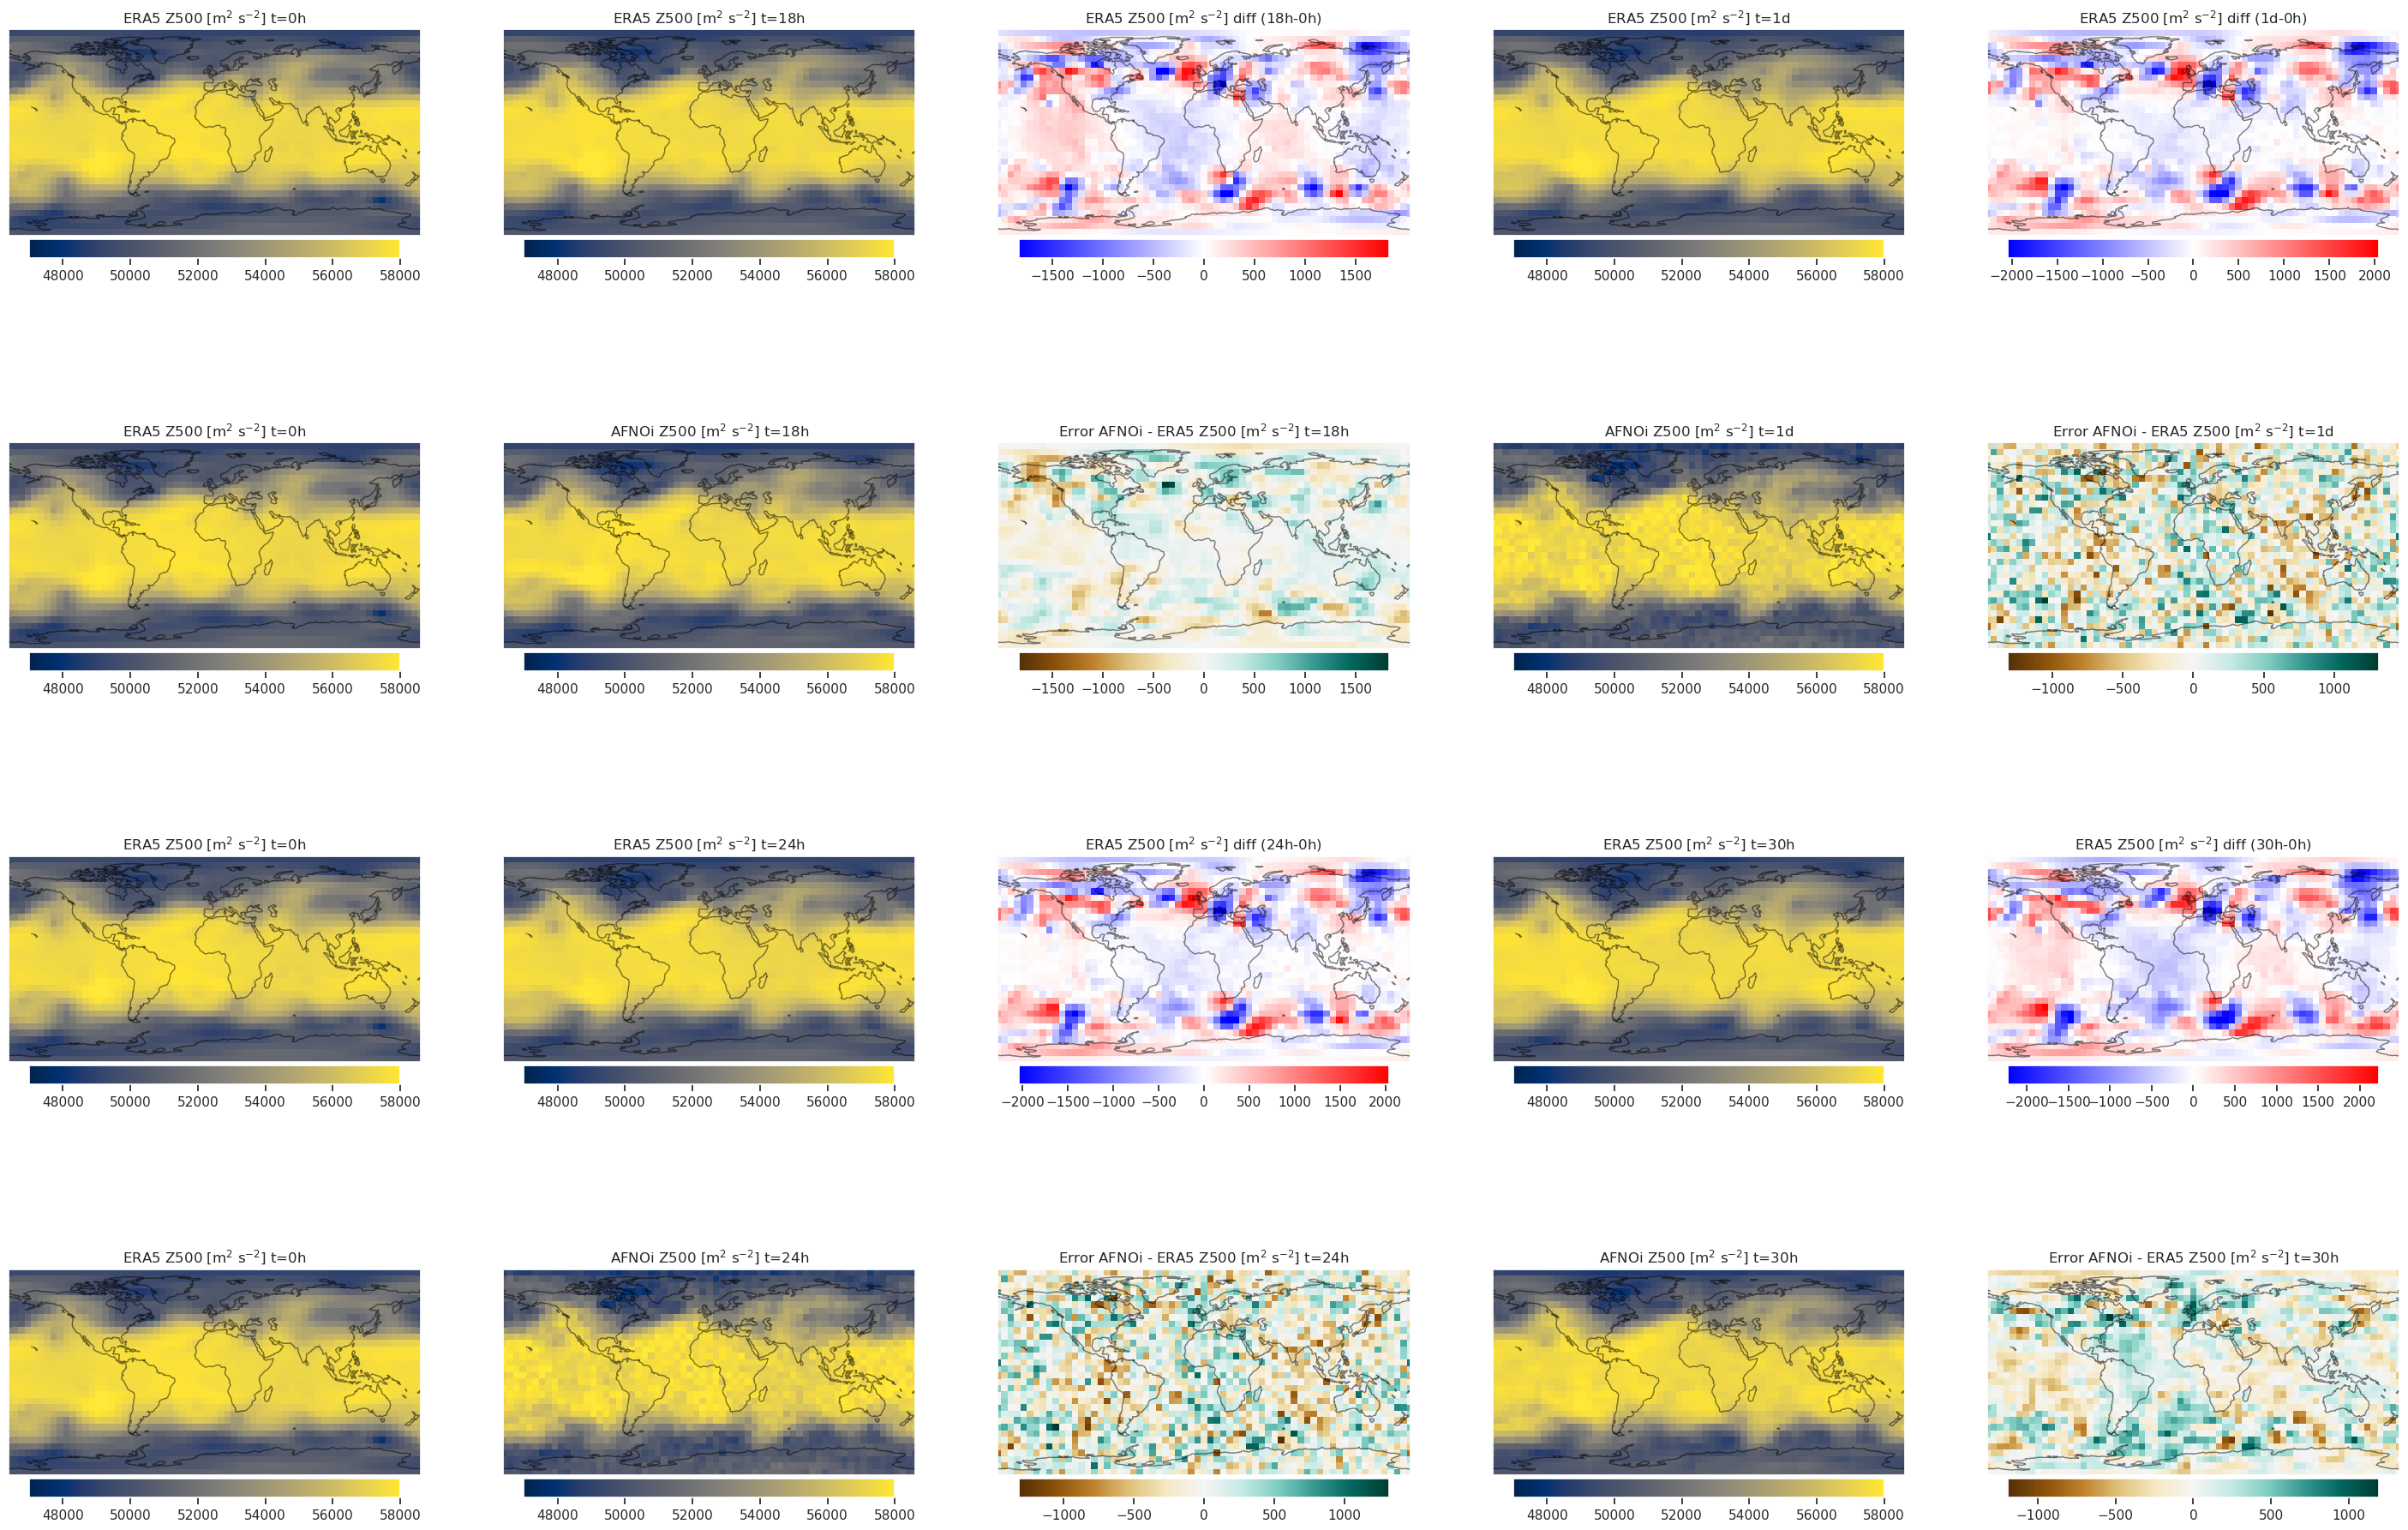

In [41]:
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

cmap_z = 'cividis'
cmap_t = 'RdYlBu_r'
cmap_diff = 'bwr'
cmap_error = 'BrBG'

def imcol(ax, data, title='', **kwargs):
    if not 'vmin' in kwargs.keys():
        mx = np.abs(data.max().values)
        kwargs['vmin'] = -mx; kwargs['vmax'] = mx
#     I = ax.imshow(data, origin='lower',  **kwargs)
    I = data.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False, 
                  rasterized=True, **kwargs)
    cb = fig.colorbar(I, ax=ax, orientation='horizontal', pad=0.01, shrink=0.90)
    ax.set_title(title)
    ax.coastlines(alpha=0.5)

fig, axs = plt.subplots(4, 5, figsize=(36, 24), subplot_kw={'projection': ccrs.PlateCarree()})
# True
for iax, var, cmap, r, t in zip(
    [0], ['z'], [cmap_z], [[47000, 58000]], [r'Z500 [m$^2$ s$^{-2}$]']):
    imcol(axs[iax,0], valid[var].isel(time=0), cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'ERA5 {t} t=0h')
    imcol(axs[iax,1], valid[var].isel(time=18), cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'ERA5 {t} t=18h')
    imcol(axs[iax,2],
        valid[var].isel(time=18)-valid[var].isel(time=0), cmap=cmap_diff, 
        title=f'ERA5 {t} diff (18h-0h)')
    imcol(axs[iax,3], valid[var].isel(time=24), cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'ERA5 {t} t=1d')
    imcol(axs[iax,4], 
        valid[var].isel(time=24)-valid[var].isel(time=0), cmap=cmap_diff, 
        title=f'ERA5 {t} diff (1d-0h)')

# AFNONet
for iax, var, cmap, r, t in zip(
    [1], ['z'], [cmap_z], [[47000, 58000]], [r'Z500 [m$^2$ s$^{-2}$]']):
    imcol(axs[iax,0], valid[var].isel(time=0), cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'ERA5 {t} t=0h')
    imcol(axs[iax,1], fc_iter[var].isel(time=0).sel(lead_time=18), cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'AFNOi {t} t=18h')
    imcol(axs[iax,2], 
        fc_iter[var].isel(time=0).sel(lead_time=18)-valid[var].isel(time=18), cmap=cmap_error,
        title=f'Error AFNOi - ERA5 {t} t=18h')
    imcol(axs[iax,3], fc_iter[var].isel(time=0).sel(lead_time=24), cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'AFNOi {t} t=1d')
    imcol(axs[iax,4], 
        fc_iter[var].isel(time=0).sel(lead_time=24) - valid[var].isel(time=24), cmap=cmap_error,
        title=f'Error AFNOi - ERA5 {t} t=1d')

for iax, var, cmap, r, t in zip(
    [2], ['z'], [cmap_z], [[47000, 58000]], [r'Z500 [m$^2$ s$^{-2}$]']):
    imcol(axs[iax,0], valid[var].isel(time=0), cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'ERA5 {t} t=0h')
    imcol(axs[iax,1], valid[var].isel(time=24), cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'ERA5 {t} t=24h')
    imcol(axs[iax,2],
        valid[var].isel(time=24)-valid[var].isel(time=0), cmap=cmap_diff, 
        title=f'ERA5 {t} diff (24h-0h)')
    imcol(axs[iax,3], valid[var].isel(time=30), cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'ERA5 {t} t=30h')
    imcol(axs[iax,4], 
        valid[var].isel(time=30)-valid[var].isel(time=0), cmap=cmap_diff, 
        title=f'ERA5 {t} diff (30h-0h)')

# AFNONet
for iax, var, cmap, r, t in zip(
    [3], ['z'], [cmap_z], [[47000, 58000]], [r'Z500 [m$^2$ s$^{-2}$]']):
    imcol(axs[iax,0], valid[var].isel(time=0), cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'ERA5 {t} t=0h')
    imcol(axs[iax,1], fc_iter[var].isel(time=0).sel(lead_time=24), cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'AFNOi {t} t=24h')
    imcol(axs[iax,2], 
        fc_iter[var].isel(time=0).sel(lead_time=24) - valid[var].isel(time=24), cmap=cmap_error,
        title=f'Error AFNOi - ERA5 {t} t=24h')
    imcol(axs[iax,3], fc_iter[var].isel(time=0).sel(lead_time=30), cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'AFNOi {t} t=30h')
    imcol(axs[iax,4], 
        fc_iter[var].isel(time=0).sel(lead_time=30)-valid[var].isel(time=30), cmap=cmap_error,
        title=f'Error AFNOi - ERA5 {t} t=30h')